In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential, Model
import random
import sklearn
from tensorflow.keras.regularizers import L1L2

False

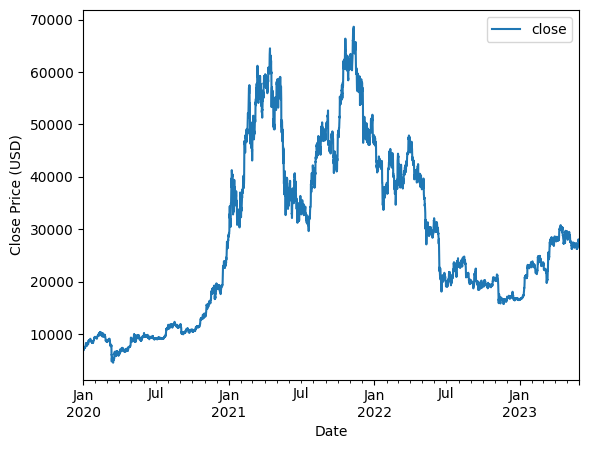

In [17]:
# Read the data from a CSV file
url = "/home/yass/code/yass2803/cryptoteller/data/BTCUSDT.csv"
df = pd.read_csv(url)
df.head()

# Change the time unit of the "open_time" column
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])

df.shape

# Plot the closing price over time
ax = df.plot(x='open_time', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization
scaler = MinMaxScaler()
close_price = df.close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

np.isnan(scaled_close).any()

In [18]:
def date_to_string(date_):
    year = str(date_.year)
    month = str(date_.month)
    day = str(date_.day)
    
    if len(day) == 1:
        day = "0" + day

    if len(month) == 1:
        month = "0" + month
        
    return year + "-" + month + "-" + day

df_sentiment = pd.read_csv("/home/yass/code/yass2803/cryptoteller/data/sentiment/aggr_sent_btc.csv")

df_dates = df[["open_time"]].copy()
df_dates.loc[:,"date"] = df_dates.open_time.apply(lambda x: date_to_string(x))

df_sentiment = df_dates.merge(df_sentiment, on="date", how="left")
df_sentiment.drop(columns="date", inplace=True)
df_sentiment.head()

,open_time,sentiment
0,2020-01-01 00:00:00,1.0
1,2020-01-01 06:00:00,1.0
2,2020-01-01 12:00:00,1.0
3,2020-01-01 18:00:00,1.0
4,2020-01-02 00:00:00,1.0


In [22]:
df_sentiment.sentiment.unique()

array([ 1., nan])

1

In [35]:

not_nan_idx = np.where(~np.isnan(df_sentiment.sentiment.values))[0]

sentiment = df_sentiment.iloc[not_nan_idx,:].sentiment.values.reshape(-1, 1)

scaled_returns_red = scaled_close[not_nan_idx]

OHE_encoder=sklearn.preprocessing.OneHotEncoder()
OHE_sentiment=OHE_encoder.fit_transform(sentiment).toarray()

n_sentiment_classes = len(OHE_encoder.categories_[0])

# Preprocessing
class Preprocessor:
    def __init__(self, SEQ_LEN=120):
        self.SEQ_LEN=SEQ_LEN
        pass
    def to_sequences(self, data,sentiment, seq_len):
        d = []
        s=[]

        for index in range(len(data) - seq_len):
            d.append(data[index: index + seq_len])
            s.append(sentiment[index:index+seq_len])

        return np.array(d), np.array(s)

    def preprocess(self, data_raw,sentiment, train_split):

        data, sentiment = self.to_sequences(data_raw, sentiment, self.SEQ_LEN)

        self.num_train = int(train_split * data.shape[0])

        X_train = data[:self.num_train, :-1, :]
        y_train = data[:self.num_train, -1, :]
        sentiment_train=sentiment[:self.num_train, :-1, :]

        X_test = data[self.num_train:, :-1, :]
        y_test = data[self.num_train:, -1, :]
        sentiment_test=sentiment[self.num_train:, :-1, :]

        return X_train, y_train, X_test, y_test, sentiment_train, sentiment_test

preprocessor=Preprocessor()
X_train, y_train, X_test, y_test, sentiment_train, sentiment_test = preprocessor.preprocess(scaled_returns_red,OHE_sentiment, train_split = 0.80)

print(f"sentiment train dtype: {sentiment_train.dtype}")

X_train.shape
X_test.shape

# Model

DROPOUT = 0.2
WINDOW_SIZE = preprocessor.SEQ_LEN - 1



def init_model(WINDOW_SIZE, n_sentiments, dropout, loss, optimizer, metrics):

    inputs_price = keras.Input(shape=(WINDOW_SIZE, 1))
    inputs_sentiment = keras.Input(shape=(WINDOW_SIZE,n_sentiments)) 
    hidden_lstm=LSTM(10, return_sequences=False, kernel_regularizer=L1L2(l1=0.05, l2=0.05))(inputs_price)

    concat = keras.layers.concatenate([hidden_lstm, inputs_sentiment[:, -1, :]], -1)
    hidden_final=keras.layers.Dense(32)(concat)
    output=keras.layers.Dense(1)(hidden_final)
    model = Model(inputs=[inputs_price, inputs_sentiment], outputs=output)

    print(model.summary())
    return model




model=init_model(WINDOW_SIZE, n_sentiment_classes, DROPOUT, 'mean_squared_error', 'adam', ["mae"])
# Training
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

es = EarlyStopping(monitor="val_loss",
                       patience=3,
                       mode="min",
                       restore_best_weights=True)

 
model.compile(
    loss='mean_squared_error',
    metrics=["mae"] ,
    optimizer="adam"
)

BATCH_SIZE = 64





sentiment train dtype: float64
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 119, 1)]     0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 119, 1)]     0           []                               
                                                                                                  
 lstm_5 (LSTM)                  (None, 10)           480         ['input_11[0][0]']               
                                                                                                  
 tf.__operators__.getitem_5 (Sl  (None, 1)           0           ['input_12[0][0]']               
 icingOpLambda)                                              

In [36]:
history = model.fit(
    [X_train, sentiment_train],
    y_train,
    epochs=6,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/6


12/12 [==============================] - 4s 125ms/step - loss: 0.5131 - mae: 0.1464 - val_loss: 0.4918 - val_mae: 0.1447
Epoch 2/6
12/12 [==============================] - 1s 69ms/step - loss: 0.4597 - mae: 0.0548 - val_loss: 0.4442 - val_mae: 0.0746
Epoch 3/6
12/12 [==============================] - 1s 70ms/step - loss: 0.4281 - mae: 0.0524 - val_loss: 0.4272 - val_mae: 0.1402
Epoch 4/6
12/12 [==============================] - 1s 71ms/step - loss: 0.3953 - mae: 0.0347 - val_loss: 0.3965 - val_mae: 0.1379
Epoch 5/6
12/12 [==============================] - 1s 67ms/step - loss: 0.3650 - mae: 0.0251 - val_loss: 0.3611 - val_mae: 0.1112
Epoch 6/6
12/12 [==============================] - 1s 69ms/step - loss: 0.3372 - mae: 0.0307 - val_loss: 0.3338 - val_mae: 0.1144


7/7 [==============================] - 0s 13ms/step - loss: 0.5049 - mae: 0.3909
MAE for the test set: 29611.606119742395


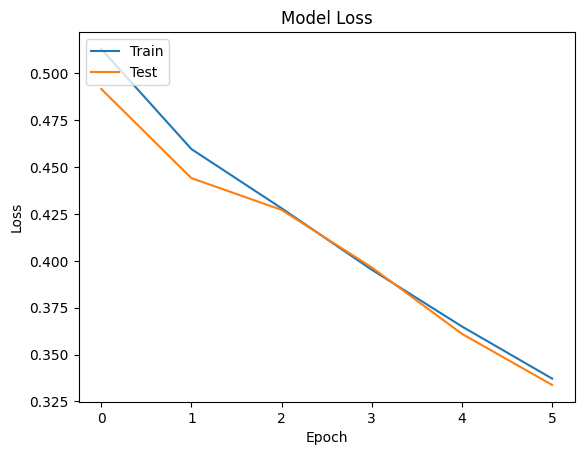

7/7 [==============================] - 1s 14ms/step


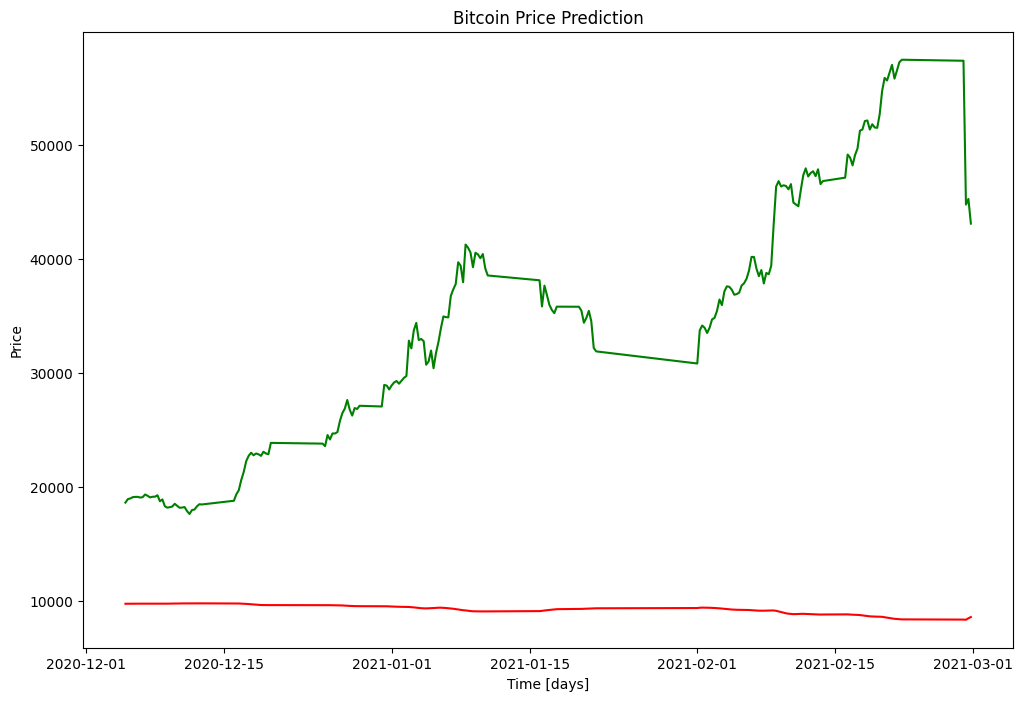

In [37]:
# Evaluation
MAE=scaler.inverse_transform([[model.evaluate([X_test, sentiment_test], y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction
y_hat = model.predict([X_test, sentiment_test])
# Inverse transform the scaled data to get the actual prices
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

# Plot the actual and predicted prices
# Prediction
date_time_test = df.iloc[not_nan_idx,:].iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.show()


7/7 [==============================] - 0s 16ms/step - loss: 0.5049 - mae: 0.3909
MAE for the test set: 29611.606119742395


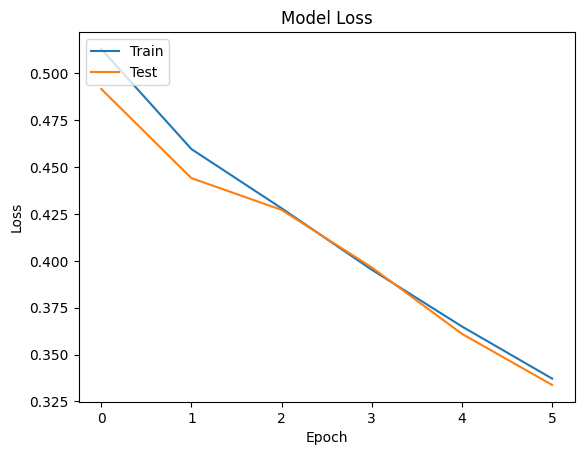

7/7 [==============================] - 0s 14ms/step
[[0.08129444]
 [0.08133794]
 [0.08138455]
 [0.08141363]
 [0.08142552]
 [0.08142267]
 [0.08141203]
 [0.08140069]
 [0.08139137]
 [0.08137524]
 [0.0813532 ]
 [0.08134051]
 [0.08133727]
 [0.08133689]
 [0.08133414]
 [0.08134336]
 [0.08137202]
 [0.08141868]
 [0.08149472]
 [0.08157745]
 [0.08164915]
 [0.08169605]
 [0.08172007]
 [0.08174044]
 [0.08176055]
 [0.08177394]
 [0.08179004]
 [0.08182485]
 [0.0818616 ]
 [0.08187816]
 [0.08187214]
 [0.0818378 ]
 [0.08178626]
 [0.08172285]
 [0.08163077]
 [0.08150357]
 [0.08133325]
 [0.08110754]
 [0.08082761]
 [0.0805091 ]
 [0.08019079]
 [0.07991818]
 [0.07971032]
 [0.07956462]
 [0.07948391]
 [0.07944255]
 [0.07942885]
 [0.0794462 ]
 [0.07944185]
 [0.07940765]
 [0.07938236]
 [0.07933107]
 [0.0792693 ]
 [0.0792022 ]
 [0.07913081]
 [0.07906565]
 [0.07896549]
 [0.07880564]
 [0.07860465]
 [0.07836366]
 [0.07816807]
 [0.07807118]
 [0.07801379]
 [0.07798015]
 [0.07795544]
 [0.07794192]
 [0.077831  ]
 [0.077661

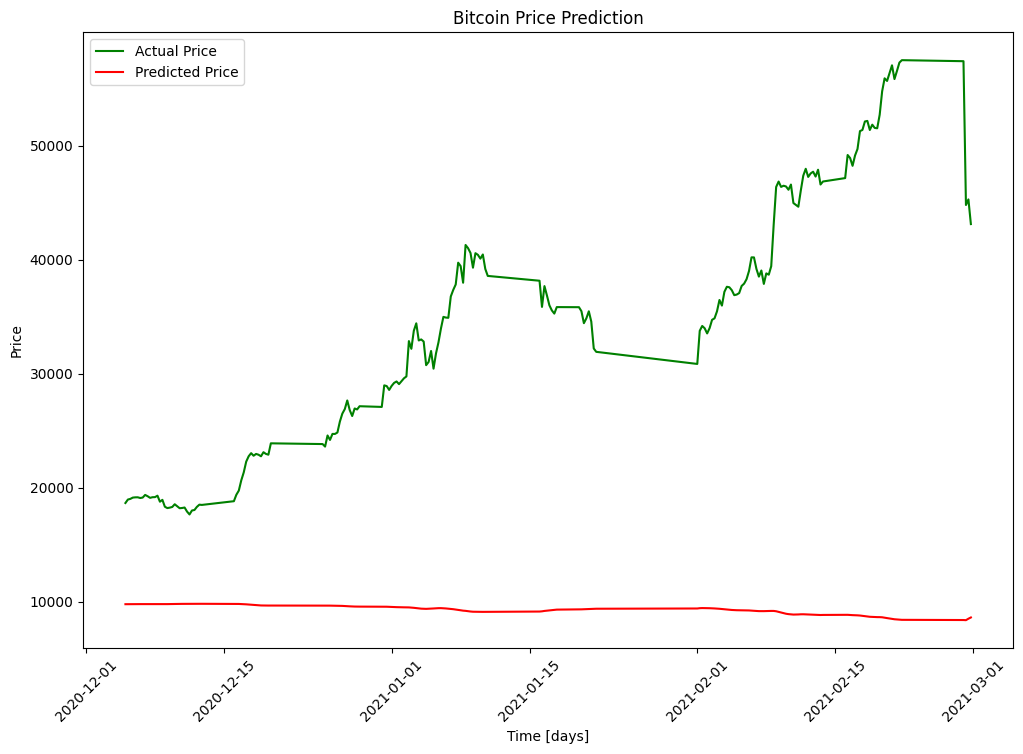

In [38]:

# Evaluation
MAE=scaler.inverse_transform([[model.evaluate([X_test, sentiment_test], y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction
y_hat = model.predict([X_test, sentiment_test])
print(y_hat)
# Inverse transform the scaled data to get the actual prices
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

# Plot the actual and predicted prices
# Prediction


date_time_test = df.iloc[not_nan_idx,:].iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.legend(loc='best')

plt.show()


In [ ]:
a=["no", "neutral", "yes"]
import random
np.array(random.choices(a, k=len(df))).reshape(-1,1)

array([['yes'],
       ['no'],
       ['neutral'],
       ...,
       ['yes'],
       ['neutral'],
       ['no']], dtype='<U7')

In [ ]:
sentiment_test

array([[[0],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]],

       [[2],
        [2],
        [0],
        ...,
        [0],
        [0],
        [2]],

       [[2],
        [0],
        [0],
        ...,
        [0],
        [2],
        [0]],

       ...,

       [[1],
        [1],
        [2],
        ...,
        [0],
        [1],
        [2]],

       [[1],
        [2],
        [2],
        ...,
        [1],
        [2],
        [0]],

       [[2],
        [2],
        [1],
        ...,
        [2],
        [0],
        [0]]])